# Common ML pipeline using CNNs

In this tutorial we're going to see a common ML/deep learning pipeline.
It consists of the following steps:
1. preprocessing and visualizing/understanding your data
2. choosing a good model (off-the-shelf or custom?) and a loss function
3. training and monitoring the model

And it involves **a lot of iteration.**

Remember: **docs, GitHub, arxiv are your friends.**

---

The problem we're going to "solve" today is to train a model to **classify** **ants** and **bees**.

<img src="img/ant.jpg" alt="an ant image" align="left" style="width: 350px;"/>
<img src="img/bee.jpg" alt="a bee image" align="center" style="width: 350px;"/>

step 1: Import libraries
---------

In [85]:
# Python's native libraries
import time
import os
import copy
from collections import defaultdict

# deep learning/vision libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv  # OpenCV

# numeric and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Libraries are your best friends
-----

If you know how to use these you can create awesome things even if you're not an expert in mathematics, statistics, ML, deep learning, etc.

### NumPy - used literally everywhere
Either explicitly like OpenCV uses it internally or implicitly with PyTorch, TensorFlow
<img src="img/numpy.png" alt="numpy" style="width: 350px;"/>

### OpenCV - the go-to computer vision library
Image processing (resize, crop, etc.), even some basic ML/deep learning algorithms for imagery
<img src="img/opencv.png" alt="opencv" style="width: 200px;"/>

### Scikit-learn - used for more classic ML algorithms 
(linear regression, PCA, Gaussian Mixture Models, SVM, etc.)
<img src="img/scikit_learn.png" alt="scikit learn" style="width: 350px;"/>

### PyTorch - used for deep learning (neural networks)
The most popular framework for deep learning aside from *TensorFlow*
<img src="img/pytorch.jpeg" alt="pytorch" style="width: 350px;"/>

step 2: Prepare the data
---------

We have about 120 training and 75 validation images for each class (ants & bees). Usually, this is a very small dataset to generalize upon, if trained from scratch. 
Since we are using transfer learning, we should be able to generalize reasonably well.

---
Dataset has been donwloaded for you

_Note:_ this dataset is a very small subset of the famous ImageNet dataset. It can be found here `<https://download.pytorch.org/tutorial/hymenoptera_data.zip>`

In [64]:
# We use data augmentation and normalization for training and only normalization for validation
# Data augmentation helps your model to better generalize to unseen images

#
# There are broadly 2 types of augmentations for images: photometric and geometric augmentations
#
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406])  # iterate over ImageNet's images and calculate these statistics
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225]) 

# These will be executed over every training/val image (handled by PyTorch's dataloader)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN_1, IMAGENET_STD_1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN_1, IMAGENET_STD_1)
    ]),
}

data_dir = 'hymenoptera_data/'

# basic error checking to check whether you correctly unzipped the dataset into the working directory
assert os.path.exists(data_dir), f'Could not find {data_dir} in working directory {os.getcwd()}n'
dirs_exist = [os.path.exists(os.path.join(data_dir, x)) for x in ['train', 'val']]
assert all(dirs_exist), f'Could not find train/val dirs check if you have train and val directly under {data_dir}.'

# ImageFolder is a PyTorch class - it expects <class1-name>, <class2-name>, ...folders under the root path you give it
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Dataloaders conviniently wraps up batch size and other details into a single object 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

#
# todo: (#1) get a single batch of images from the train dataloader and print it's shape
#
print((next(iter(dataloaders['train'])))[0].shape)

# cuda:0 is the 1st GPU on your system if you had more than 1 you could use the 2nd by setting cuda:1, etc.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}, (cuda:0 is prefered over CPU).")  

torch.Size([4, 3, 224, 224])
Using device cuda:0, (cuda:0 is prefered over CPU).


step 3: Understand your data (visualizations)
---------

Important terms:
**Ground Truth (GT)** - correct labels

Created either:
1. Purely by humans - somebody sits down, given instructions, follows those instructions and labels the data (boring)
2. Semi-automatic - a part of the labels are produced by some algorithms, humans just slightly modify those
3. Fully-automatic - some kind of autonomous pipeline that creates the GT labels

_Note: if we have synthetic data (SX) than we're always getting GT "for free" i.e. the 3rd option above._

Extremely laborous semantic segmentation labeling:

<img src="img/gt.png" alt="ground truth for semantic segmentation" align="center" style="width: 450px;"/>


In our case somebody had to go through images and click either bee or ant - it's error prone so usually every image is passed to multiple annotators and usually by majority-voting we get the correct label (with high probability).


Training dataset size: 244 images, Validation dataset size: 153 images
Classes in our training/val datasets: ['ants', 'bees']
Shape of batch of images: torch.Size([4, 3, 224, 224])
Image grid shape=torch.Size([3, 228, 906])
-4.053115898461357e-09 1.0000000236034394


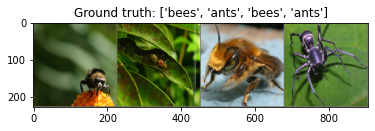

In [75]:
def imshow_tensor(tensor, title=None):
    """Imshow for Tensor."""
    # convert PyTorch Tensor to numpy and change from channel first to channel last (2 common image layouts HWC & CHW)
    # similar to RBG<->BGR confusion...
    img = tensor.numpy().transpose((1, 2, 0))
    img = IMAGENET_STD_1 * img + IMAGENET_MEAN_1 # denormalize
    #
    # todo: (#4) find min and max element and try and see what the range is before and after clip
    #
    print(np.min(img), np.max(img))
    
    img = np.clip(img, 0, 1)  
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f'Training dataset size: {dataset_sizes["train"]} images, Validation dataset size: {dataset_sizes["val"]} images')

#
# todo: (#2) (understanding how ImageFolder works) add dummy class under train/ and run again
#
class_names = image_datasets['train'].classes
print(f"Classes in our training/val datasets: {class_names}")

img_batch, classes = next(iter(dataloaders['train'])) # Get a batch of training data
print(f'Shape of batch of images: {img_batch.shape}')

image_grid = torchvision.utils.make_grid(img_batch) # Make an image grid from batch
print(f'Image grid shape={image_grid.shape}')  # Knowing shapes of your tensors is helpful for debugging!

#
# todo: (#3) add some photometric transform to train dataloader and run again (brightness, contrast, saturation, hue)
# What do you notice happened? Why would we want to do this?
#

# Ground truth is the correct label of the image - contrast that with predicted label that the model outputs
imshow_tensor(image_grid, title='Ground truth: ' + str([class_names[x] for x in classes]))

# step 4: Define the core util functions
------------------

In [4]:
def train_model(model, criterion, optimizer, num_epochs=25):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    # preds = torch.argmax(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            metrics[phase+"_loss"].append(epoch_loss)
            metrics[phase+"_acc"].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {(time_elapsed // 60):.0f}m {time_elapsed % 60:.0f}s')
    print('Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

Visualize model predictions
---------



In [76]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            tmp, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow_tensor(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# Count how many trainable weights the model has <- just for having a feeling for how big the model is
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def display_metrics_charts(metrics):
    plt.subplots_adjust(wspace=1, hspace=1)
    fig, ax = plt.subplots(nrows=2, ncols=2)
    keys = list(metrics.keys())
    cnt = 0
    for row in ax:
        for col in row:
            col.set_title(keys[cnt])
            col.plot(metrics[keys[cnt]])
            cnt += 1

Off-the-shelf vs custom models
----------------------

There are many popular models in torchvision - like **ResNets**, **VGG**, **MobileNets**, etc.

But sometimes you may wish to create your own model - because it's SOTA and hasn't yet been integrated into PyTorch.

![title](img/resnetvgg.png)

step 5: Fine-tuning off-the-shelf models (transfer learning)
----------------------------------

Here, we need to freeze all of the layers of the network except the final layer. 

We need to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

Loss functions are really important! Our model is as good as our loss function.
If it correlates perfectly with the performance we want our model to have, super! If not well we'll have to have some kind of visual inspections as the curves themselves won't cut it.

We'll be using this loss function (**cross entropy**) for classification:
![cross entropy loss](img/cross_entropy.png)

**Arxiv and GitHub are your good friends!**

In [88]:
#
# First just run this cell
#

SUPPORTED_MODELS = ['resnet18', 'vgg16', 'mnetv2']
model_name = SUPPORTED_MODELS[1]

if model_name == SUPPORTED_MODELS[0]:
    model = torchvision.models.resnet18(pretrained=True)
elif model_name == SUPPORTED_MODELS[1]:
    model = torchvision.models.vgg16(pretrained=True)
elif model_name == SUPPORTED_MODELS[2]:
    model = torchvision.models.mobilenet_v2(pretrained=True)
else:
    raise Exception(f'Model {model_name} not supported yet.')

print(f"Using {model_name}, number of trainable params before freezing {count_parameters(model)}")
    
# Freeze parameters - making them non-trainable
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
finetuned_model = copy.deepcopy(model)
if model_name == SUPPORTED_MODELS[0]:
    #
    # todo: (#5) open https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py to understand why fc
    #
    num_ftrs = finetuned_model.fc.in_features
    finetuned_model.fc = nn.Linear(num_ftrs, 2)
elif model_name == SUPPORTED_MODELS[1]:
    # todo: (#6) modify model so as to have fully-connected layer at it's output for binary classification
    num_ftrs = finetuned_model.classifier[-1].in_features
    finetuned_model.classifier[-1] = nn.Linear(num_ftrs, 2)

    print('to implement.')
elif model_name == SUPPORTED_MODELS[2]:
    # todo: (#7) modify model so as to have fully-connected layer at it's output for binary classification
    num_ftrs = finetuned_model.classifier[-1].in_features
    finetuned_model.classifier[-1] = nn.Linear(num_ftrs, 2)
    print('to implement.')

print(f"Num of params after freezing: {count_parameters(finetuned_model)}")

model = model.to(device)
finetuned_model = finetuned_model.to(device)  # place the model onto the GPU (you hopefully have one)

#
# todo: (#8) whats the biggest model of the 3?
#

# loss function - this pretty much defines the model
criterion = nn.CrossEntropyLoss()

# 
# todo: (#9) open https://arxiv.org/pdf/1512.03385.pdf <- originally used SGD we'll stick with Adam, why?
# 
# We optimize only the trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()))

Using vgg16, number of trainable params before freezing 138357544
to implement.
Num of params after freezing: 8194


Predict after fine-tuning procedure
-----

Epoch 0/2
----------
train Loss: 0.1600 Acc: 0.9303
val Loss: 0.0782 Acc: 0.9608

Epoch 1/2
----------
train Loss: 0.1473 Acc: 0.9508
val Loss: 0.0972 Acc: 0.9542

Epoch 2/2
----------
train Loss: 0.1016 Acc: 0.9467
val Loss: 0.0850 Acc: 0.9673

Training complete in 0m 11s
Best val Acc: {best_acc:4f}


<Figure size 432x288 with 0 Axes>

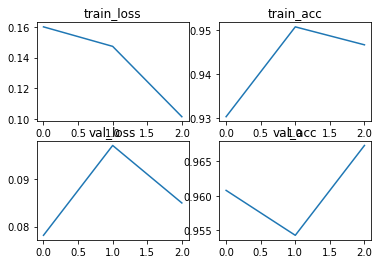

In [90]:
#
# Run the cell to start training your model
#
num_epochs = 3

# change num_epochs to smaller number for faster iteration
finetuned_model, metrics = train_model(finetuned_model, criterion, optimizer, num_epochs)  
display_metrics_charts(metrics)

2.7418136649970393e-09 0.996078369140625


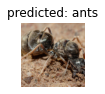

-4.053115898461357e-09 1.0000000236034394


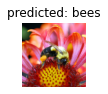

0.035294096589088386 0.9921568689346314


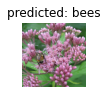

2.7418136649970393e-09 1.0000000236034394


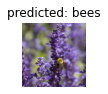

0.05490195131301884 0.9921568908691407


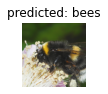

2.7418136649970393e-09 1.0000000236034394


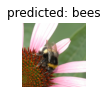

In [84]:
#
# Run this cell to qualitatively assess model's performance 
#
visualize_model(finetuned_model)

step 6: Using a custom (CNN) model
-----

Generic off-the-shelf models are good. But in industry when you want to create the best product for your users,
you want to use custom models which were designed for that very specific task! (and not generic image classification models)

number of params in model 109986
Epoch 0/24
----------
train Loss: 0.6943 Acc: 0.5246
val Loss: 0.7086 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.6865 Acc: 0.5861
val Loss: 0.6744 Acc: 0.6013

Epoch 2/24
----------
train Loss: 0.6691 Acc: 0.6393
val Loss: 0.6577 Acc: 0.5948

Epoch 3/24
----------
train Loss: 0.6377 Acc: 0.6598
val Loss: 0.6484 Acc: 0.6340

Epoch 4/24
----------
train Loss: 0.5930 Acc: 0.6967
val Loss: 0.6333 Acc: 0.6405

Epoch 5/24
----------
train Loss: 0.5833 Acc: 0.6803
val Loss: 0.6311 Acc: 0.6340

Epoch 6/24
----------
train Loss: 0.5999 Acc: 0.6844
val Loss: 0.6660 Acc: 0.6144

Epoch 7/24
----------
train Loss: 0.6065 Acc: 0.6885
val Loss: 0.6650 Acc: 0.5686

Epoch 8/24
----------
train Loss: 0.5884 Acc: 0.6803
val Loss: 0.6152 Acc: 0.6863

Epoch 9/24
----------
train Loss: 0.6117 Acc: 0.7008
val Loss: 0.7465 Acc: 0.6078

Epoch 10/24
----------
train Loss: 0.5670 Acc: 0.7008
val Loss: 0.6220 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.5735 Acc: 0.6885

<Figure size 432x288 with 0 Axes>

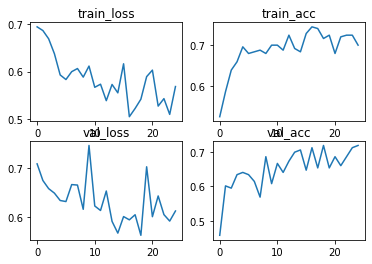

In [86]:
#
# Custom models inherit from nn.Module and you define 2 functions in their interface __init__ and forward
#

# Note: this is also a toy example but it showcases the workflow of developing a new architecture
class CustomCNN(nn.Module):

    def __init__(self):
        super().__init__()
        num_of_channels = [3, 16, 32, 64, 128]
        kernel_sizes = [3, 3, 3, 3]
        stride_sizes = [2, 2, 2, 2]
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = nn.Conv2d(num_of_channels[0], num_of_channels[1], kernel_size=kernel_sizes[0], stride=stride_sizes[0])
        self.conv2 = nn.Conv2d(num_of_channels[1], num_of_channels[2], kernel_size=kernel_sizes[1], stride=stride_sizes[1])
        self.conv3 = nn.Conv2d(num_of_channels[2], num_of_channels[3], kernel_size=kernel_sizes[2], stride=stride_sizes[2])
        self.conv4 = nn.Conv2d(num_of_channels[3], num_of_channels[4], kernel_size=kernel_sizes[3], stride=stride_sizes[3])
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Linear(num_of_channels[-1] * 7 * 7, 2)
        
    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.relu(self.conv2(y))
        y = self.relu(self.conv3(y))
        y = self.relu(self.conv4(y))
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y
    
custom_cnn = CustomCNN().to(device)
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, custom_cnn.parameters()))

print(f"number of params in model {count_parameters(custom_cnn)}")

#
# todo: (#10) Why is acc 0.5? Anybody?
#
model_conv, metrics = train_model(custom_cnn, criterion, optimizer_conv, num_epochs=25)

plt.subplots_adjust(wspace=1, hspace=1)
fig, ax = plt.subplots(nrows=2, ncols=2)
keys = list(metrics.keys())
cnt = 0
for row in ax:
    for col in row:
        col.set_title(keys[cnt])
        col.plot(metrics[keys[cnt]])
        cnt += 1


step 7: Demystyfing CNNs - visualizations
-----
We are going to hook up our function to all layers, so that we save their outputs

In [91]:
assert model_name == SUPPORTED_MODELS[1], 'Visualization should be done on VGG.' 
assert num_epochs >= 3, 'Visualization should be done on network trained at least with 25 epochs.'

# This will allow us to visualize what each layer learned as well as what it outputed (activations)
visualization = {}

def hook_fn(m, inp, outp):
    visualization[m] = outp

def register_visualization_hooks(net):
    for name, layer in net._modules.items():
        # If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
        if isinstance(layer, nn.Sequential):
            register_visualization_hooks(layer)
        else:
            # it's a non sequential. Register a hook
            layer.register_forward_hook(hook_fn)

register_visualization_hooks(finetuned_model)

We are now going to visualize few convolutional layer kernels (filters) from the finetuned vgg16 model from above.

In [92]:
def visualize_kernels(visualization):
    display_number_of_layers = 3
    for i, layer in enumerate(visualization):
        
        # we will skip all non-conv layers
        if not isinstance(layer, nn.Conv2d):
            continue
        
        if display_number_of_layers == 0:
            return
                
        # Normalize filter values to 0-1 so we can visualize them:
        weights = layer.weight
        f_min, f_max = weights.min(), weights.max()
        weights = (weights - f_min) / (f_max - f_min)

        # Let's transpose array so that we can visualize it easier
        weights = weights.detach().cpu().numpy().transpose((3, 2, 1, 0))
        
        print(f'Layer {i} with structure {layer}')
        n_filters, ix = 6, 1
        for i in range(n_filters):
            # get the filter
            f = weights[:, :, :, i]
            # plot each channel separately
            for j in range(3):
                # specify subplot and turn of axis
                ax = plt.subplot(n_filters, 3, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(f[:, :, j], cmap='gray')
                ix += 1
        plt.show()
        display_number_of_layers -= 1


The dark squares will indicate small or inhibitory weights, and the light squares represent large or excitatory weights.

Layer 0 with structure Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


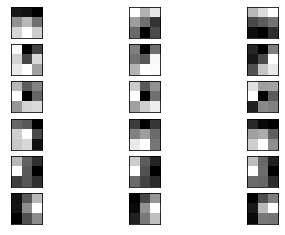

Layer 2 with structure Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


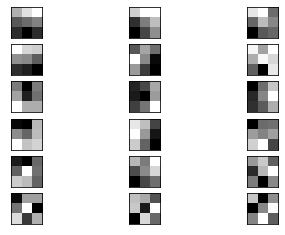

Layer 5 with structure Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


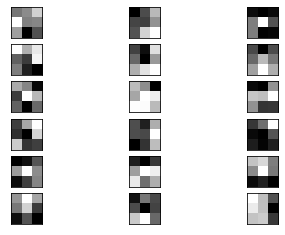

In [93]:
visualization_image = next(iter(dataloaders['val']))[0][0].unsqueeze(0)
# run the image through the model to gather kernel/filter visualizations (we're expecting finetuned_model to be vgg16 here)
finetuned_model(visualization_image.to(device))

visualize_kernels(visualization)

Visualization of kernels can be informative on first, maybe second conv layer, however later on it does not tell us much, and it can be hard to interpret. Another informative thing we can do in order to understand CNNs better, is to visualize the activations given a specific image

In [94]:
def visualize_feature_maps(visualization):
    for i, layer in enumerate(visualization):
        # we will visualize only conv layers
        if not isinstance(layer, nn.Conv2d):
            continue
        
        activations = visualization[layer].cpu()
        plt.matshow(activations[0,0, :, :], cmap='viridis')
        plt.title(f'Layer {i} Format: {layer} \n')
        if i == 0:
            for j in range(1, 4):
                plt.matshow(activations[0,j, :, :], cmap='viridis')
                plt.title(f'Layer {i} Format: {layer} \n')

Let's feed an image to the model in order to see filter activations for it. We will now show that image, as well as display filter activations on the given image.

0.003921580076217679 0.996078369140625


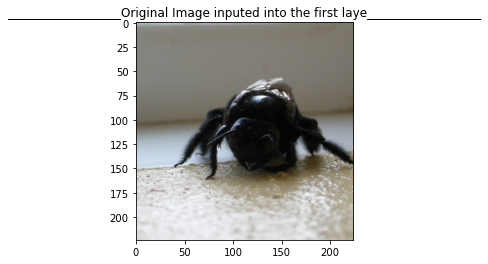

0.003921580076217679 0.996078369140625


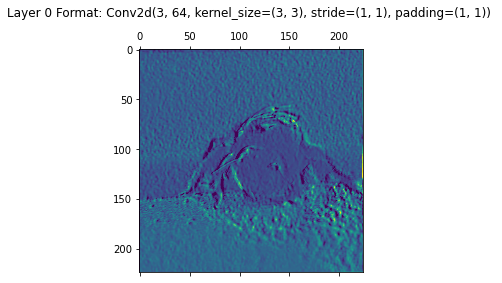

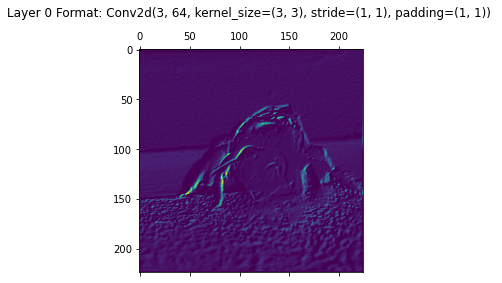

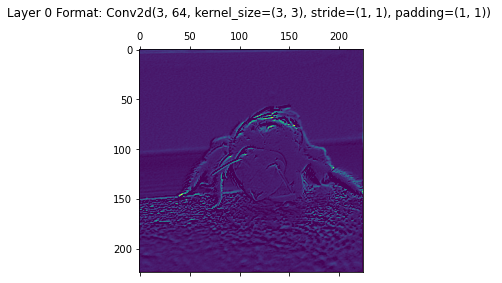

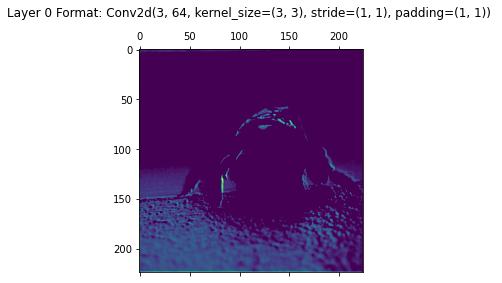

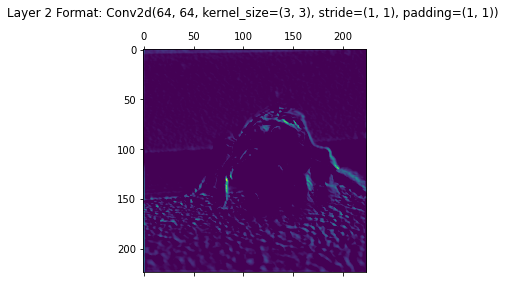

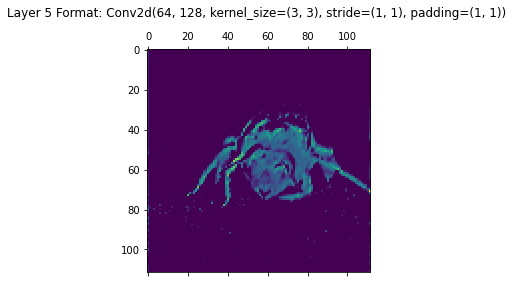

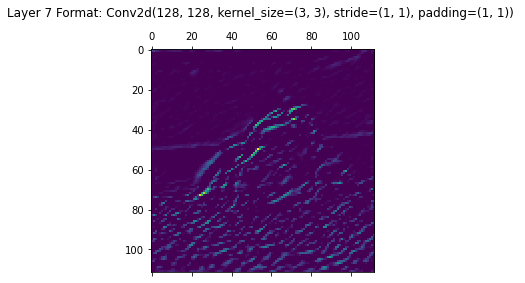

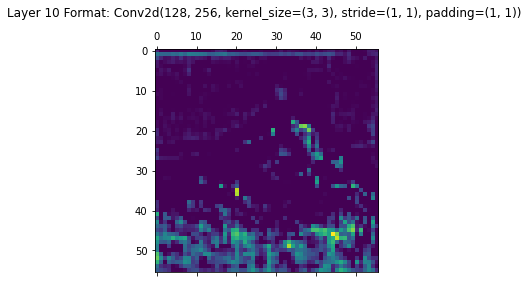

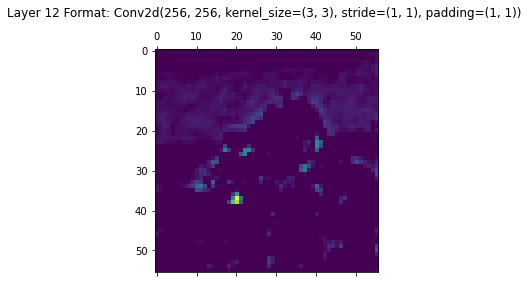

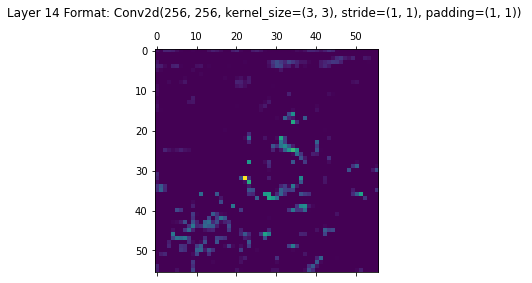

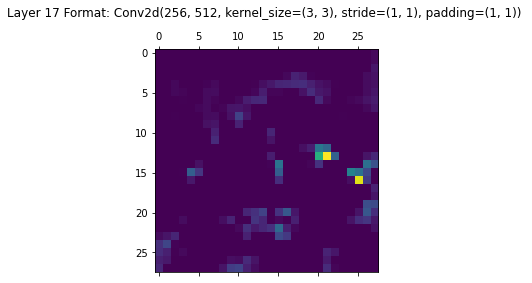

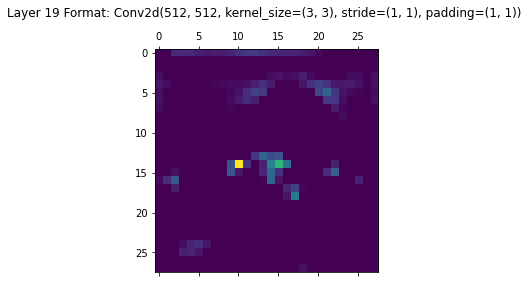

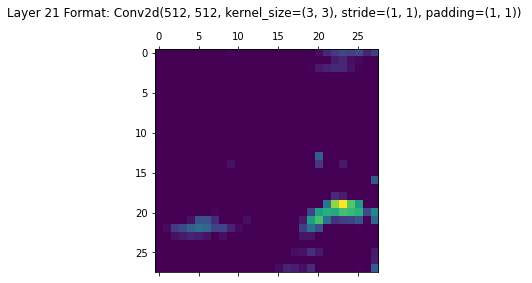

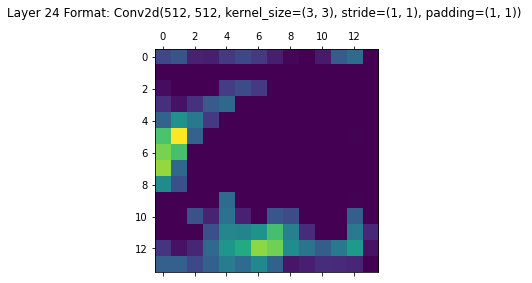

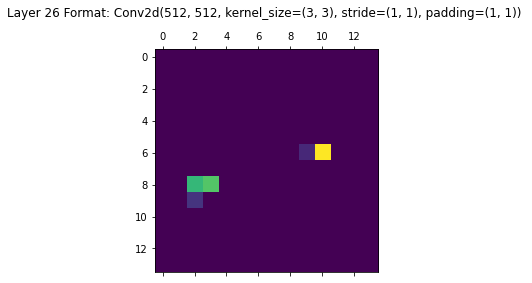

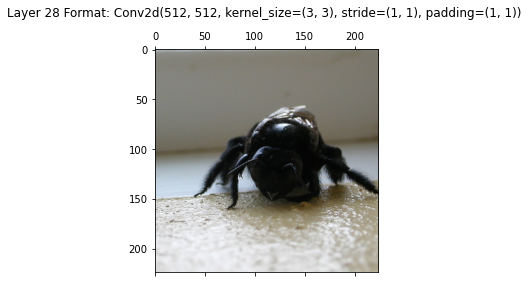

In [95]:
imshow_tensor(visualization_image.cpu()[0], '___________________Original Image inputed into the first laye___________________')

visualize_feature_maps(visualization)
imshow_tensor(visualization_image.cpu()[0])

As you can see, in the first layer fitlers are catching pretty simple patterns (e.g. horizontal edges), however, going into the deeper layers, the patterns get more complicated and no longer resamble the input image in any way.

There is also one more visualization way of understanding CNNs, which is by visualizing the image that would activate network the most for a given class or layer. This is also achieved by minimizing the loss, however not by modifying the weights of the layers but the image itself!

Below you can find examples which were made by following the strategy explained above. Authors have started from certain input image, and modified it in a way to maximise the activations of certain layers/classes and got following results (Examples from Deep Dream):

<img src="img/deepdreamdoggo.png" alt="deep dream doggo" style="width: 600px;"/>

<img src="img/deepdreambird.png" alt="deep dream bird" style="width: 600px;"/>

<img src="img/deepdreamlisa.png" alt="deep dream Mona Lisa" style="width: 600px;"/>